# **From transcriptomics to mechanistic models of signalling**

- Pablo Rodriguez Mier (pablo.rodriguez-mier@uni-heidelberg.de)
- Denes Turei (turei.denes@gmail.com)<br><br>
_[Saez-Rodriguez Group](https://saezlab.org/), Institute for Computational Biomedicine, Heidelberg University_<br><br>

Cellular signalling networks are the communication pathways that govern the behaviour of cells. They allow cells to receive and process external signals, such as growth factors and hormones, and respond appropriately by activating specific gene expression programs or inducing cellular behaviours like proliferation, migration, and differentiation. Deterioration of these signalling networks can lead to various diseases, including cancer, metabolic disorders, and immune disorders. Understanding the regulatory mechanisms of signalling networks is critical to developing effective therapies for these diseases.

One approach to discover signalling network alterations from omics data is through the use of **upstream regulatory pathway analysis,** which aims to identify the **transcription factors** and **upstream signalling regulators** that control the expression of downstream genes. Changes in gene expression patterns can be used as cues to **infer the activity of transcription factors (TFs)** that control the transcription of those genes, using specific enrichment tests and prior *(i.e. database or literature)* knowledge of TF regulons *(i.e. the sets of genes regulated by each TF).* Once the activities of TFs are inferred from gene expression, the potential upstream signalling cascades responsible for the changes in TF activities can be explored using **causal reasoning.** To do causal reasoning, we start off from large, general signalling networks retrieved from databases and called **prior knowledge networks (PKNs).** Our aim is to highlight the pathways within this network that provide a plausible explanation of the activity patterns. Causal reasoning is implemented in our software package **[CARNIVAL](https://saezlab.github.io/CARNIVAL)<sup>1</sup>.** By using powerful algorithms and general purpose integer optimization solvers, CARNIVAL explores the vast space of potential signalling alterations to identify a parsimonious signalling network that explains the measurements.

In this course, participants will learn how to process differential gene expression data to estimate transcription factor activities with **[Decoupler](https://decoupler-py.readthedocs.io/)<sup>2</sup>,** obtain and process PKNs with **[OmniPath](https://omnipathdb.org/)<sup>3,4</sup>** and **[pypath](https://pypath.omnipathdb.org/),** and use **CARNIVAL** to infer signalling networks that explain the activity patterns. In this course we will use carnival through **[CORNETO](https://github.com/saezlab/corneto)**, a software package that provides uniform and convenient interface not only to CARNIVAL, but other similar methods.

https://permedcoe.eu/training/virtual-course-from-transcriptomics-to-mechanistic-models-of-signalling/

<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/overall-course-view.png" alt="maxflow" width="1024"/>
<figcaption>
<strong>Figure 1. Bird's eye view of the workflow.</strong> The workflow presented in this tutorial is widely applied to analyse the mechanisms behind diseases, experimental perturbations, drug effects, etc. The main goal of the workflow is to highlight within a large, generic signalling network the components that play a role in the mechanisms behind the investigated phenomena. First we use gene expression signatures from databases to infer the activities of certain network components from transcriptomics data. Then we map the activities onto a large, generic signalling network and use causal reasoning to find the relevant subnetworks that represent the mechanisms of interest.
</figcaption>
</figure>

## Learning outcomes
At the end of these sessions, the participants will be able to:

- Obtain custom networks of causal interactions from public databases using OmniPath/pypath.
- Combine these networks with molecular biological activities from experimental data using Decoupler.
- Apply causal reasoning to find the most plausible causal mechanisms that explain the observed activity patterns using CARNIVAL.
- Use CARNIVAL with CORNETO to customise the contextualisation of signalling networks.

## Links to use during the course
- [This notebook on Google Colab](https://colab.research.google.com/drive/1llrWl4S5dpRlk7h6NxFnKiN-2I0UMAWn)
- [Live document](https://docs.google.com/document/d/1TWp8HLjZGeEQcmNnTx88DzTLbn4jcBwGday6ngw5j1Y/edit?usp=sharing)
- [Slides](https://docs.google.com/presentation/d/1GLlTFKXme8NDL9AOmpcj6oONaIS3sc7PGCdDopvmLeI/edit?usp=sharing)

## 1. Load some util functions

Make sure that you have cloned the `PerMedCoE_tools_virtual_course_2023` repository into the `permedcoe` directory, located in the same place as this notebook. We will import the functions from `utils.py` to make our life easier.

In [1]:
from permedcoe.utils import (
    plot,
    get_problem_values,
    get_selected_edges_and_nodes,
    set_problem_value,
)

# 2. Database knowledge

<figure>
<img src="https://static.omnipathdb.org/omnipath-contents-applications.png" alt="maxflow" width="800"/>
<figcaption>
<strong>Figure 2. OmniPath database contents and applications.</strong> OmniPath is a database built from over 170 original resources. It consists of five independent database domains: 1) network of molecular interactions; 2) enzyme-PTM relationships; 3) protein complexes; 4) annotations of gene, protein or other molecule's functions, localisations, structures, etc; 5) roles of proteins in intercellular communication (ligand, receptor, adhesion, transporter, etc). OmniPath is most often used for the analysis of systems level molecular data (omics data); middle (green) section. Some tools commonly making use of OmniPath data are shown in the bottom (yellow) section.
</figcaption>
</figure>

## 2.1. Custom networks of causal interactions from public databases

### 2.1.1. Sources

Comprehensive, systems level knowledge about molecular interactions typically comes from the following sources:

*   Expert curation of literature
*   High-throughput (HTP) screenings (AP-MS, yeast-2-hybrid, ChIP-Seq, etc)
*   *In silico* prediction (e.g. from functional motives of sequences, or interactions of orthologous genes in other organisms)
*   Literature mining by natural language processing software (e.g. [INDRA](https://indra.bio/)<sup>5</sup>)

### 2.1.2. Quality

Traditionally literature curation is considered to be the most reliable, however, requiring the contribution of highly skilled experts, it is expensive, hence the volume of the available data is relatively small. In general, there is a **trade-off between quality and coverage:** to cover less known molecular players or putative interactions, we have to account for a higher proportion of false positive interactions. A smaller network is not only higher quality, but easier to process, and as we will see later, causal reasoning is a computationally intensive method.

### 2.1.3. Representations

Computational representations of biological data are always simplified compared to reality. The simplified representation might be an advantage as it enables the application of various mathematical methods for inference or simulation. It can be also a disadvantage though, because certain biological mechanisms might be lost or imperfectly represented. The most common representations of molecular interactions are classified in the Systems Biology Graphical Notation ([SBGN](https://sbgn.github.io/))<sup>6</sup> standard. Here we restrict ourselves to the most important points:

*   We use the so called **activity flow** representation, which is a network of molecules connected by **directed,** either **stimulatory** or **inhibitory** edges
*   We use this representation because it is suitable for causal reasoning
*   We acknowledge that in many cases it fails to fully capture the biological reality
*   The representations more faithful to biology, such as *process description* (e.g. [Reactome](https://reactome.org/), [KEGG](https://www.genome.jp/kegg/kegg3a.html)) would reduce the performance of our inference due to lower coverage and more complex networks
*   A large amount of further interactions are available from HTP screens, however these are undirected, missing the causality information, which is essential for causal reasoning (the largest database of such undirected interactions is [IntAct](https://www.ebi.ac.uk/intact/))

<figure>
<img src="https://static.omnipathdb.org/causality.png" alt="maxflow" width="800"/>
<figcaption>
<strong>Figure 3. Activity flow representation and its limitations.</strong> Many proteins and other molecular players have more than two states of activity: they are not simply active or inactive, but they have more than two different behaviours, each of these regulated in a certain way. In the activity flow representation, a protein's activity can be understood along a single dimension, and the edges are either activatory or inhibitory. This representation obviously can not deal with the situations when a protein has multiple, alternatively regulated activities (a): in this example, A activates a behaviour of B when it does something to C; but also A inhibits the behaviour of B when it does something to D; hence the sign of the A→B edge is problematic. Currently this is a limitation, all easy solutions are imperfect: (b) we can remove the effect sign from the A→B edge, but our tools can not handle "neutral" signs; (c) we can split node B to two variants (e.g. phosphorylated and dephosphorylated), but this introduces excess complexity, resulting computationally heavier models, and also in many cases the database information is not available at this level of granularity; (d) we can collapse the A→B→C and A→B→D cascades into indirect connections, however in a larger network this is not always possible.
</figcaption>
</figure>

### 2.1.4. OmniPath

Literature curated interaction data in activity flow representation has been collected by many groups over the past two decades, and is scattered across many resources. The largest ones are [SIGNOR](https://signor.uniroma2.it/), [SignaLink](http://signalink.org/) and [SPIKE](https://www.cs.tau.ac.il/~spike/), but dozens of others exist. To combine all these in single, easily available access point, we created a new database called [*OmniPath*](https://omnipathdb.org/)<sup>*3,4*</sup>*.* OmniPath is built by the Python package *pypath*, which downloads data from the original sources and brings all of them to a uniform format. Then it makes available the combined data by a public web service. We also developed clients for R, Python and Cytoscape to esily retrieve data from the web service. Here we will use the Python client, and in the first example we download the original, literature curated signalling network dataset.

<figure>
<img src="https://static.omnipathdb.org/omnipath-architecture-old.png" alt="maxflow" width="800"/>
<figcaption>
<strong>Figure 4. Computational architecture of OmniPath.</strong> The <a href="https://pypath.omnipathdb.org/" target="_blank">pypath</a> Python module downloads and processes the original resources and builds the OmniPath databases. The databases are publicly available by the web service at <a href="https://omnipathdb.org/" target="_blank">omnipathdb.org</a>. The users can retrieve the data directly from pypath, or by HTTP queries to the web service (returns JSON or tabular formats), and most commonly, by one of the client software (<a href="https://r.omnipathdb.org/" target="_blank">R</a>, <a href="https://omnipath.readthedocs.io/" target="_blank">Python</a> and <a href="https://apps.cytoscape.org/apps/omnipath" target="_blank">Cytoscape</a>).
</figcaption>
</figure>

In [2]:
import omnipath as op

curated_pathways = op.interactions.OmniPath.get(genesymbols = True)
curated_pathways

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP25,P48995,CALM3,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
1,P0DP24,P48995,CALM2,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
2,P0DP23,P48995,CALM1,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
3,Q03135,P48995,CAV1,TRPC1,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P14416,P48995,DRD2,TRPC1,True,True,False,True,True,False,1,TRIP:18261457,TRIP,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92257,P08581,O14964,MET,HGS,True,True,False,True,True,False,2,HPRD:8380735;SPIKE_LC:16713569,HPRD;PhosphoPoint;SPIKE_LC;Wang,4,3,2,16713569;8380735
92258,P08581,Q6VN20,MET,RANBP10,True,False,False,False,False,False,1,HPRD:14684163,HPRD;PhosphoPoint;Wang,3,3,1,14684163
92259,P06239,P16070,LCK,CD44,True,False,False,False,False,False,2,HPRD:8576267;SPIKE_LC:16189514,HPRD;PhosphoPoint;SPIKE_LC,3,2,2,16189514;8576267
92260,P04626,Q07889,ERBB2,SOS1,True,True,False,True,True,False,2,HPRD:11173924;SPIKE_LC:16713569,HPRD;PhosphoPoint;SPIKE_LC;Wang,4,3,2,11173924;16713569


### 2.1.5. More interactions

<figure>
<img src="https://static.omnipathdb.org/network-overview.png" alt="maxflow" width="800"/>
<figcaption>
<strong>Figure 5. Netork data in OmniPath.</strong> (A) Number of network components in each dataset; (B) number of directed, stimulatory and inhibitory interactions; (C) percentage of proteins having at least one interaction within a given dataset.
</figcaption>
</figure>

In the curated dataset (called *omnipath* for historical reasons) every interaction must have literature references and direction, even if those come from different sources. The so called *extra* datasets include further directed interactions without literature references:

*   *kinaseextra*: kinase-substrate interactions
*   *pathwayextra*: interactions with effect sign (stimulation vs. inhibition)
*   *ligrecextra*: ligand-receptor interactions

With the *pathwayextra* dataset we get about 35,000 more interactions:

In [3]:
more_pathways = op.interactions.AllInteractions.get(
    include = ['omnipath', 'pathwayextra'],
    genesymbols = True,
)

more_pathways

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,type,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP23,P48995,CALM1,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
1,P0DP25,P48995,CALM3,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
2,P0DP24,P48995,CALM2,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,post_translational,1,1,3,11290752;11983166;12601176
3,Q03135,P48995,CAV1,TRPC1,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,post_translational,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P14416,P48995,DRD2,TRPC1,True,True,False,True,True,False,1,TRIP:18261457,TRIP,post_translational,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120034,P01106,Q96BZ4,MYC,PLD4,True,False,True,True,False,True,1,SPIKE_LC:17093053,SPIKE_LC,post_translational,1,0,1,17093053
120035,P01106,Q6ZMI0,MYC,PPP1R21,True,False,True,True,False,True,1,SPIKE_LC:17093053,SPIKE_LC,post_translational,1,0,1,17093053
120036,P01106,Q659C4,MYC,LARP1B,True,True,False,True,True,False,1,SPIKE_LC:17093053,SPIKE_LC,post_translational,1,0,1,17093053
120037,P01106,Q9NR48,MYC,ASH1L,True,True,False,True,True,False,1,SPIKE_LC:17093053,SPIKE_LC,post_translational,1,0,1,17093053


Finally, using all protein-protein interaction (PPI, i.e. post-translational interaction) datasets we get roughly 8,000 more interactions. These datasets overlap, hence the small increase in this last step.

In [4]:
all_pathways = all_pathways = op.interactions.PostTranslational.get(
    genesymbols = True,
)

all_pathways

0.00B [00:00, ?B/s]

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP23,P48995,CALM1,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
1,P0DP25,P48995,CALM3,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
2,P0DP24,P48995,CALM2,TRPC1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
3,Q03135,P48995,CAV1,TRPC1,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P14416,P48995,DRD2,TRPC1,True,True,False,True,True,False,1,TRIP:18261457,TRIP,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134277,P12931,Q8TDD2,SRC,SP7,True,False,False,False,False,False,0,NaN,ProtMapper;Sparser_ProtMapper,2,1,None,None
134278,O00168,Q13794,FXYD1,PMAIP1,True,False,False,False,False,False,1,ProtMapper:22442718,ProtMapper;Sparser_ProtMapper,2,1,1,22442718
134279,Q05397,Q5SRH9,PTK2,TTC39A,True,False,False,False,False,False,1,ProtMapper:30055645,ProtMapper;Sparser_ProtMapper,2,1,1,30055645
134280,P20248,Q8TDN4,CCNA2,CABLES1,True,False,False,False,False,False,1,ProtMapper:11733001,ProtMapper;SIGNOR_ProtMapper,2,1,1,11733001


### 2.1.6. Less interactions

Depending on the application, smaller networks might be prefereable. Obviously, we want to select the most reliable edges. We present two approaches: first, we set a threshold based on `curation_effort` (a combination of number of resources and references); second, we select a few reputable resources and fetch only those from OmniPath.

In [5]:
highly_curated = curated_pathways[curated_pathways.curation_effort > 2]

print(f'Selected {highly_curated.shape[0]} interactions out of {curated_pathways.shape[0]}.')

Selected 17445 interactions out of 92262.


In [6]:
curated_core = op.interactions.OmniPath.get(
    resources = ['SIGNOR', 'SignaLink3', 'SPIKE', 'CA1'],
    genesymbols = True,
)

print(f'The 4 resources above contain {curated_core.shape[0]} interactions.')

0.00B [00:00, ?B/s]

The 4 resources above contain 66722 interactions.


### 2.1.7. Which resources are available?

Above we selected 4 resources from the *omnipath* dataset. For each dataset we can see a complete list of the available resources. Importantly, not all resources listed here are fully included in OmniPath or in this particular dataset: from some only certain subsets are included, others are only informative, showing that certain interactions occur also in those resources.

In [7]:
op.interactions.OmniPath.resources()

('ACSN',
 'ACSN_SignaLink3',
 'ARN',
 'Adhesome',
 'AlzPathway',
 'BEL-Large-Corpus_ProtMapper',
 'Baccin2019',
 'BioGRID',
 'BioGRID_ICELLNET',
 'CA1',
 'CancerCellMap',
 'CellChatDB',
 'CellChatDB-cofactors',
 'CellPhoneDB',
 'CellPhoneDB_ICELLNET',
 'CellTalkDB',
 'DEPOD',
 'DIP',
 'DLRP_talklr',
 'DOMINO',
 'DeathDomain',
 'Dinarello2013_ICELLNET',
 'ELM',
 'EMBRACE',
 'Fantom5_LRdb',
 'GO-lig-rec_ICELLNET',
 'Guide2Pharma',
 'Guide2Pharma_CellPhoneDB',
 'Guide2Pharma_ICELLNET',
 'Guide2Pharma_LRdb',
 'Guide2Pharma_talklr',
 'HPMR',
 'HPMR_ICELLNET',
 'HPMR_LRdb',
 'HPMR_talklr',
 'HPRD',
 'HPRD-phos',
 'HPRD_KEA',
 'HPRD_LRdb',
 'HPRD_MIMP',
 'HPRD_talklr',
 'HuRI',
 'I2D_CellPhoneDB',
 'ICELLNET',
 'IMEx_CellPhoneDB',
 'InnateDB',
 'InnateDB-All_CellPhoneDB',
 'InnateDB_CellPhoneDB',
 'InnateDB_ICELLNET',
 'InnateDB_SignaLink3',
 'IntAct',
 'IntAct_CellPhoneDB',
 'KEA',
 'KEGG-MEDICUS',
 'Kinexus_KEA',
 'Kirouac2010',
 'Kirouac2010_ICELLNET',
 'LMPID',
 'LRdb',
 'Li2012',
 'Lit-B

### 2.1.8. TF-target interactions

The TF-target interactions, also called *gene regulatory network* (GRN), represent the regulons of transcription factors, as each TF is connected to the genes it regulates. These are available in OmniPath the same way as we have seen above. Currently 3 TF-target datasets are available:

*   *collectri:* **CollecTRI<sup>7</sup>** is a very new, comprehensive resource of gene regulation, covering more than 1,200 TFs, ~68 thousands of interactions and ~40 thousands literature references, all these from 13 original databases and the authors own literature curation
*   *dorothea:* **DoRothEA<sup>8</sup>** is a comprehensive resource of gene regulation combining 18 original resources, data extracted from reviews, ChIP-Seq data, TF binding site predictions and gene expression based inference; it classifies interactions into five confidence levels from A to E
*   *tf_target:* data from 8 original literature curated resources processed directly by OmniPath

As said above, we use the TF regulons to infer TF activities from gene expression. Now we take a direct look at the regulons data, later we will see how Decoupler works with this data for activity inference.

When accessing DoRothEA, by default the two highest confidence levels (A and B) are included. Let's see an example where we include also level C.

In [8]:
dorothea = op.interactions.Dorothea.get(
    dorothea_levels = {'A', 'B', 'C'},
    genesymbols = True,
)

dorothea

0.00B [00:00, ?B/s]

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P01106,O14746,MYC,TERT,False,True,False,True,True,False,7,,DoRothEA;HTRIdb_DoRothEA;KEGG_DoRothEA;RegNetw...,7,1,1,
1,P84022,P05412,SMAD3,JUN,False,True,False,True,True,False,6,DoRothEA:10022869,DoRothEA;RegNetwork_DoRothEA;TFactS_DoRothEA;T...,5,1,1,10022869
2,Q13485,P05412,SMAD4,JUN,False,True,False,True,True,False,6,DoRothEA:10022869,DoRothEA;RegNetwork_DoRothEA;TFactS_DoRothEA;T...,5,1,1,10022869
3,P08047,P04075,SP1,ALDOA,False,True,False,True,True,False,7,DoRothEA:8524331,DoRothEA;ORegAnno_DoRothEA;RegNetwork_DoRothEA...,6,1,1,8524331
4,P04637,P08069,TP53,IGF1R,False,False,True,True,False,True,6,,DoRothEA;PAZAR_DoRothEA;ReMap_DoRothEA;RegNetw...,6,1,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32612,Q5HY98,Q9Y4F3,ZNF766,MARF1,True,False,False,False,True,True,3,,ARACNe-GTEx_DoRothEA;DoRothEA;ReMap_DoRothEA,3,1,1,
32613,P51522,O60494,ZNF83,CUBN,True,False,False,False,True,True,3,,ARACNe-GTEx_DoRothEA;DoRothEA;ReMap_DoRothEA,3,1,1,
32614,P51522,Q15365,ZNF83,PCBP1,True,False,False,False,True,True,3,,ARACNe-GTEx_DoRothEA;DoRothEA;ReMap_DoRothEA,3,1,1,
32615,P51522,Q7KZF4,ZNF83,SND1,True,False,False,False,True,True,3,,ARACNe-GTEx_DoRothEA;DoRothEA;ReMap_DoRothEA,3,1,1,


### 2.1.9. Ambiguous directions and effect signs

In a small number of cases different resources report different direction or sign (stimulation vs. inhibition) for the same interaction. This can be either a mistake, or often it represents biological reality: the curators focused on different aspects of the interaction and assumed different roles for the interacting partners. This also highlights a limitation of the activity flow representation. Some tools come with even more limitations, as they are not able to handle this ambiguity. To address this issue, we applied a majority vote among resources and references to get a consensus direction and sign. Let's see how successful this attempt was. First count the ambiguous signs in the `curated_pathways` network



In [9]:
curated_pathways[
    curated_pathways.is_stimulation &
    curated_pathways.is_inhibition
].shape[0]

1366

Interactions with ambiguous signs constitute only about 1.5 % of this dataset. In the majority vote ties can occur, in this case the interaction remains ambiguous. Let's count the ambiguous signs according to the consensus columns:

In [10]:
curated_pathways[
    curated_pathways.consensus_stimulation &
    curated_pathways.consensus_inhibition
].shape[0]

133

About 90 % of the ambiguity has been eliminated, for the remaining there is no perfect solution, one option could be to consider all these inhibitory.

### 2.1.10. Mouse and rat

Experimental data often comes from model animals. The OmniPath web service provides interaction data for mouse and rat, translated by orthologous gene pairs. Not all genes have known orthologues, hence this dataset is much smaller than its human original.

In [11]:
mouse_omnipath = op.interactions.OmniPath.get(
    organism = 'mouse',
    genesymbols = True,
)

mouse_omnipath

0.00B [00:00, ?B/s]

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0DP26,Q61056,Calm1,Trpc1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
1,P0DP28,Q61056,Calm3,Trpc1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
2,P0DP27,Q61056,Calm2,Trpc1,True,False,True,True,False,True,3,TRIP:11290752;TRIP:11983166;TRIP:12601176,TRIP,1,1,3,11290752;11983166;12601176
3,P49817,Q61056,Cav1,Trpc1,True,True,False,True,True,False,13,DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...,DIP;HPRD;IntAct;Lit-BM-17;TRIP,5,5,8,10980191;12732636;14551243;16822931;18430726;1...
4,P61168,Q61056,Drd2,Trpc1,True,True,False,True,True,False,1,TRIP:18261457,TRIP,1,1,1,18261457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28272,P05480,Q99JZ7,Src,Errfi1,True,False,False,False,False,False,2,ProtMapper:26280531;iPTMnet:26280531,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,26280531
28273,P48025,Q9EPB4,Syk,Pycard,True,False,False,False,False,False,2,ProtMapper:25605870;iPTMnet:25605870,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,25605870
28274,Q9QVP9,Q9EPB4,Ptk2b,Pycard,True,False,False,False,False,False,2,ProtMapper:27796369;iPTMnet:27796369,ProtMapper;RLIMS-P_ProtMapper;iPTMnet,3,2,1,27796369
28275,Q8BRK8,Q9Z1T6,Prkaa2,Pikfyve,True,False,False,False,False,False,1,iPTMnet:24070423,iPTMnet,1,1,1,24070423


If you work with other model organisms, you can use the [*pypath.utils.homology*](https://pypath.omnipathdb.org/notebooks/manual.html#Homology-translation) module to translate any dataset to your organism of interest.

## 2.2. Annotations

The *Annotations* database of OmniPath provides details about the **function, localisation, structure,** and many other features of genes and proteins, altogether from a total of 81 resources. First let's see a complete list of these:

In [12]:
op.requests.Annotations.resources()

('Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CSPA',
 'CSPA_celltype',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'ComPPI',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HPMR_complex',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniProt_keyword',
 'UniProt_location',
 'UniProt_tissue',
 'UniProt_topology',
 'Vesiclepedia',
 'Zhong2015',
 'connectomeDB2020',
 'iTALK',
 'kinase.com'

Now we take a closer look at some of the annotation resources that are useful in the current context.

### 2.2.1. Pathway responsive signatures

These can be used by Decoupler to infer **activities of pathways** from gene expression data, similarly to the TF activity inference. The signatures in the [**PROGENy**](https://saezlab.github.io/progeny/)<sup>**9**</sup> resource have been compiled from a large number of pathway perturbation transcriptomics datasets. The scores express how the gene responds to the activation of the given pathway.

In [13]:
op.requests.Annotations.get(resources = ['PROGENy'], wide = True)

0.00B [00:00, ?B/s]

,uniprot,genesymbol,entity_type,p_value,pathway,weight
0,P35250,RFC2,protein,0.001655,EGFR,1.470647
1,P35250,RFC2,protein,0.121273,Androgen,-1.284376
2,P35250,RFC2,protein,0.000704,Hypoxia,-2.049501
3,P35250,RFC2,protein,0.023814,Estrogen,2.409824
4,P35250,RFC2,protein,0.803718,PI3K,-0.238926
...,...,...,...,...,...,...
233408,Q96A11,GAL3ST3,protein,0.988972,Trail,-0.005215
233409,Q96A11,GAL3ST3,protein,0.607089,Hypoxia,0.063501
233410,Q96A11,GAL3ST3,protein,0.000065,VEGF,-0.690819
233411,Q96A11,GAL3ST3,protein,0.236295,PI3K,-0.228038


The activites of well known, canonical pathways already represent a biologically interpretable result; moreover, these can be used in causal reasoning to find the most plausible mechanisms behind the condition of interest.

A very similar approach goes one more step upstream and attempts to infer **cytokine activities** from expression data, using cytokine responsive signatures from the [**CytoSig**](https://cytosig.ccr.cancer.gov/)**<sup>15</sup>** resource. In our experience, the performance of this method is not satisfying yet.

In [14]:
op.requests.Annotations.get(resources = ['CytoSig'], wide = True)

0.00B [00:00, ?B/s]

,uniprot,genesymbol,entity_type,cytokine,cytokine_genesymbol,score,target_genesymbol
0,Q9NPC4,A4GALT,protein,P22301,IL10,-0.035369,A4GALT
1,Q9NPC4,A4GALT,protein,P29965,CD40L,0.064452,A4GALT
2,Q9NPC4,A4GALT,protein,P01133,EGF,0.005696,A4GALT
3,Q9NPC4,A4GALT,protein,P48061,CXCL12,0.004607,A4GALT
4,Q9NPC4,A4GALT,protein,Q9UHA7,IL36,0.039171,A4GALT
...,...,...,...,...,...,...,...
200485,P14207,FOLR2,protein,P01583,IL1A,-0.006865,FOLR2
200486,P14207,FOLR2,protein,P10600,TGFB3,0.000000,FOLR2
200487,P14207,FOLR2,protein,P50591,TRAIL,-0.016629,FOLR2
200488,P14207,FOLR2,protein,P48061,CXCL12,0.191014,FOLR2


### 2.2.2. Miscellaneous annotations

The rest of the annotation resources are not directly connected to the current topic, but they can be used for a number of supplementary tasks:

*   **Filter networks:** in certain situations we are interested in a smaller segment of the network, and we want to filter it, for example, by function or localisation; e.g. select only the intracellular proteins, or proteins expressed in adipose tissue, or proteins of the TGF-beta pathway, etc.
*   **Enrichment analysis:** with Decoupler it's really easy to do enrichment analysis, for this the whole [MSigDB](http://www.gsea-msigdb.org/gsea/index.jsp) and several other resources are available in OmniPath
*   **Interpretation:** annotations, potentially together with enrichment analysis, might be helpful for the exploration and interpretaton of the results at any stage

Showing these features in detail goes beyond our current scope, we only provide here an example where we create a network of the TGF-beta pathway only.

In [15]:
slk_pathways = op.requests.Annotations.get(resources = ['SignaLink_pathway'], wide = True)
slk_pathways

0.00B [00:00, ?B/s]

,uniprot,genesymbol,entity_type,pathway
0,P20963,CD247,protein,T-cell receptor
1,P43403,ZAP70,protein,Receptor tyrosine kinase
2,P43403,ZAP70,protein,T-cell receptor
3,Q9NYJ8,TAB2,protein,Toll-like receptor
4,Q9NYJ8,TAB2,protein,Innate immune pathways
...,...,...,...,...
2482,COMPLEX:P00533_Q15303,COMPLEX:EGFR_ERBB4,complex,JAK/STAT
2483,COMPLEX:P00533_Q15303,COMPLEX:EGFR_ERBB4,complex,Receptor tyrosine kinase
2484,COMPLEX:P26992_P40189_Q6UWB1,COMPLEX:CNTFR_IL27RA_IL6ST,complex,JAK/STAT
2485,COMPLEX:Q06330_Q9Y618,COMPLEX:NCOR2_RBPJ,complex,Notch


In [16]:
tgfb_uniprots = set(slk_pathways.uniprot[slk_pathways.pathway == 'TGF'])
len(tgfb_uniprots)

297

In [17]:
tgfb_network = curated_pathways[
    curated_pathways.source.isin(tgfb_uniprots) &
    curated_pathways.target.isin(tgfb_uniprots)
]

tgfb_network

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
210,P31749,O15111,AKT1,CHUK,True,True,False,True,True,False,31,BioGRID:10485711;BioGRID:11278366;BioGRID:1571...,BioGRID;CancerCellMap;Cui2007;ELM;HPRD;HPRD-ph...,30,18,13,10485710;10485711;11278366;12048203;15710601;1...
343,O43318,P45985,MAP3K7,MAP2K4,True,True,False,True,True,False,41,ACSN:11274345;ACSN:12738796;ACSN:18855897;ACSN...,ACSN;ACSN_SignaLink3;Cui2007;HPRD;KEGG-MEDICUS...,13,9,39,10391247;11274345;11280761;11460167;11477091;1...
344,P45985,O43318,MAP2K4,MAP3K7,True,False,False,False,False,False,1,HPRD:12556533,HPRD;PhosphoPoint,2,2,1,12556533
765,P63165,P29590,SUMO1,PML,True,True,False,True,True,False,28,BioGRID:22875967;DIP:25497731;HPRD:11080164;HP...,BioGRID;DIP;HPRD;IntAct;LMPID;Lit-BM-17;SIGNOR...,10,9,17,11080164;11948183;15388847;16189514;17036045;1...
865,Q5SW24,P36896,DACT2,ACVR1B,True,False,True,True,False,True,4,SPIKE:17197390;SPIKE:21718540;SPIKE_LC:1719739...,SPIKE;SPIKE_LC,2,1,2,17197390;21718540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91241,P27361,Q13177,MAPK3,PAK2,True,False,False,False,False,False,1,HPRD:12226077,HPRD;PhosphoPoint,2,2,1,12226077
91698,P36897,O43318,TGFBR1,MAP3K7,True,True,False,True,True,False,1,HPRD:18758450,Cui2007;HPRD;Wang,3,3,1,18758450
91808,P05412,P04150,JUN,NR3C1,True,True,False,True,True,False,3,HPRD:7823959;HPRD:8733011;SPIKE_LC:16713569,HPRD;SPIKE_LC;Wang,3,2,3,16713569;7823959;8733011
91926,P36894,P31273,BMPR1A,HOXC8,True,False,False,False,False,False,1,HPRD:11139569,HPRD;PhosphoPoint,2,2,1,11139569


# 3. From transcriptomics to Transcription Factor (TF) activities with Decoupler


Decoupler<sup>2</sup> is a package containing different statistical methods to extract biological activities from omics data within a unified framework. It allows to flexibly test any method with any prior knowledge resource and incorporates methods that take into account the sign and weight. It can be used with any omic, as long as its features can be linked to a biological process based on prior knowledge. For example, in transcriptomics gene sets regulated by a transcription factor, or in phospho-proteomics phosphosites that are targeted by a kinase.



<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/decoupler.png" alt="maxflow" width="600"/>
<figcaption>
<strong>Figure 6. Decoupler methods and workflow.</strong> Decoupler combines omics data and database knowledge to infer biological activities by one or more of its 12 statistical methods.
</figcaption>
</figure>

Importing Decoupler takes unusually long (approx. 1 min), since it uses [Numba](https://numba.pydata.org/) just-in-time (JIT) compiler to accelerate the functions, and the compilation happens at import time:

In [18]:
import decoupler as dc
import pandas as pd

C:\Users\pablo\micromamba\envs\permedschool\lib\site-packages\decoupler\method_wmean.py:37: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  pvals = np.where(pvals == 0.0, 1.0, pvals).astype(nb.f4)


## 3.1. How Decoupler accesses prior knowledge?

Decoupler has its own submodule to access OmniPath, and it even has dedicated functions for accessing DoRothEA and PROGENy. It will soon have a similar shortcut for CollecTRI, it's just happens to be so new that we only finished working on it two weeks before this course. Let's see what kind of tables Decoupler creates from these resources. These tables have slightly different column layout than the ones we get directly from OmniPath, to make them suitable input for Decoupler's activity and enrichment inference methods. Unlike the `omnipath` module, `decoupler` uses DoRothEA confidence levels A-C by default. The letters are mapped to numeric weights in order to make use of them in the activity estimation:

In [19]:
dorothea_abc = dc.omnip.get_dorothea(levels = ('A', 'B', 'C'))

dorothea_abc

0.00B [00:00, ?B/s]

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


PROGENy too has its dedicated function. This function is able to use [*pypath.utils.homology*](https://pypath.omnipathdb.org/notebooks/manual.html#Homology-translation) in the background to convert the data to mouse or other organisms by gene orthology. We would be glad to demonstrate it here, but it requires the download of a large amount of data from UniProt and Ensembl, and would take too long (longer than 10 minutes at the first run, much shorter at subsequent runs as the data is already cached).

---



In [20]:
dc.omnip.get_progeny()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


The generic function `get_resource` is able to download any resource from OmniPath; another generic function `translate_net` translates any data frame to the desired organism, but due to the above mentioned reasons, we don't recommend to try it now.

In [21]:
dc.omnip.get_resource('SignaLink_pathway')

0.00B [00:00, ?B/s]

,genesymbol,pathway
0,CD247,T-cell receptor
1,ZAP70,Receptor tyrosine kinase
2,ZAP70,T-cell receptor
3,TAB2,Toll-like receptor
4,TAB2,Innate immune pathways
...,...,...
1139,DKFZp686J04131,T-cell receptor
1140,NFATC2,B-cell receptor
1141,NFATC2,T-cell receptor
1142,RASGRP1,B-cell receptor


## 3.2. TF activity inference

Here, we will see how to **use Decoupler to estimate transcription factor activities from a contrast experiment (disease vs healthy)** from which we have bulk RNA-Seq data. The data consists of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming Growth Factor (TGF-β) (available at GEO [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151251)).

**For simplicity, we will skip the raw data processing part and we will assume that we have already done the differential expression analysis<sup>10</sup> between stimulated and control cells.**

> NOTE: The content of this tutorial is based on [Decoupler's tutorial on bulk data](https://decoupler-py.readthedocs.io/en/latest/notebooks/bulk.html). If you are interested in running the differential analysis from yourself, we uploaded the part of the tutorial related to transcriptomics data processing and TF estimation in this Google Colab notebook: https://colab.research.google.com/drive/13Z-_S-hT0s4E4J7Iuv6vr58aCkQF-A4g


In [23]:
df_deseq2 = pd.read_csv('dataset/deseq2_stimulated_vs_control.csv').set_index('GeneName')
df_deseq2

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257060,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154700,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.508000,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633200,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.120000,-0.523154,0.297741,-1.070903,0.284213,0.387995


C:\Users\pablo\micromamba\envs\permedschool\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


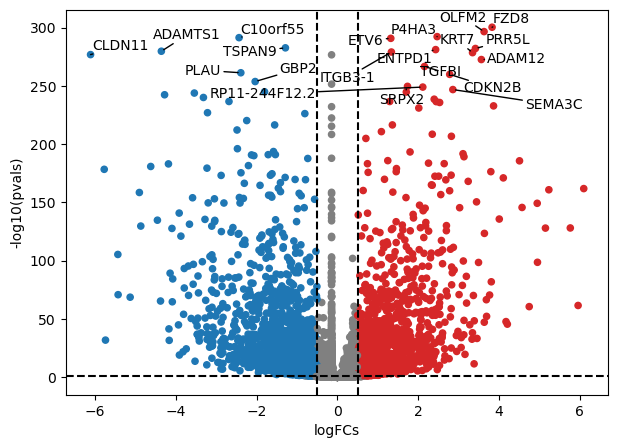

In [24]:
dc.plot_volcano_df(df_deseq2, x='log2FoldChange', y='padj', top=20)

To estimate TF activities, first we have to create a matrix of samples vs. features with our variable of interest.

In [25]:
de_matrix = df_deseq2.filter(['log2FoldChange']).transpose().set_index([['TGFB']])
de_matrix

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
TGFB,0.050407,-0.068949,0.129368,-0.523892,0.483006,-0.106232,-0.263293,-0.111849,-0.259617,-0.552901,...,-0.522687,0.095733,0.149205,0.167408,-0.241009,-0.240886,-0.265368,-0.523154,-0.366886,-0.424278


To estimate TF activities, we use the DoRothEA regulons retrieved in the previous section (`dorothea_abc`) and our differential expression data (`df_deseq2`) with Decoupler's *weighted mean* (`run_wmean`) method. We can also point Decoupler to the columns to use in the prior knowledge data frame, though in this example the column names are already the defaults.

In [26]:
tf_activities = dc.run_wmean(
    mat=de_matrix,
    net=dorothea_abc,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
)

tf_activities

Running wmean on mat with 1 samples and 17575 targets for 281 sources.
Infering activities on 1 batches.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.51s/it]


(           AHR        AR    ARID2    ARID3A      ARNT     ASCL1      ATF1  \
 TGFB -0.350407 -0.091229  0.12783 -0.129297  0.127194 -0.079646  0.061338   
 
          ATF2      ATF3      ATF4  ...    ZNF217     ZNF24    ZNF263  \
 TGFB  0.14682 -0.074791  0.199839  ... -0.322295 -0.113742 -0.092303   
 
         ZNF274    ZNF384    ZNF584    ZNF592   ZNF639    ZNF644    ZNF740  
 TGFB -0.325304  0.144941 -0.126608 -0.192469  0.16079  0.297295  0.048625  
 
 [1 rows x 281 columns],
            AHR        AR     ARID2    ARID3A      ARNT     ASCL1      ATF1  \
 TGFB -2.350634 -0.950547  1.373847 -0.647991  1.679946 -0.316277  1.094961   
 
           ATF2      ATF3      ATF4  ...    ZNF217     ZNF24    ZNF263  \
 TGFB  1.670326 -0.443797  2.728922  ... -1.171252 -0.458491 -1.339405   
 
         ZNF274    ZNF384    ZNF584    ZNF592    ZNF639    ZNF644    ZNF740  
 TGFB -1.655754  2.040157 -0.392155 -0.833227  1.527251  1.223668  0.757116  
 
 [1 rows x 281 columns],
            AHR     

The results are better readable if the TFs with the highest activity changes are visualised on a barplot. The call above returned a tuple of four data frames, which contain the raw weighted mean scores, their normalised and  corrected versions, and in the last we find the p-values. Here we plot the normalised scores:

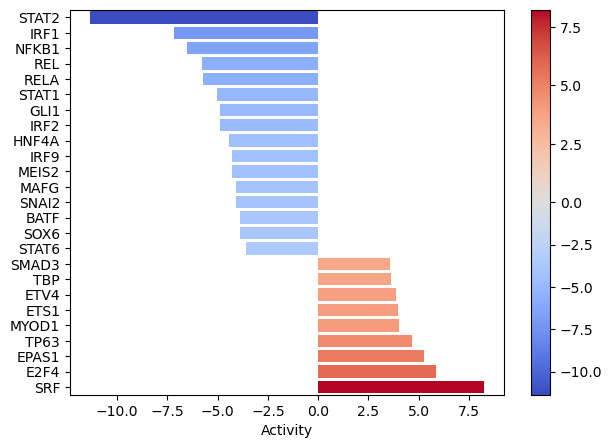

In [27]:
dc.plot_barplot(tf_activities[1], 'TGFB', top = 25, vertical = True)

SRF is the transcription factor which shows the highest activity increment in response to TGF-beta stimulation. It's interesting to see which genes are its targets and how their expression change. Below we see that most of the targets are higher expressed in the TGF-beta samples. The three distinct values on the x-axis correspond to DoRothEA's A, B and C confidence levels.

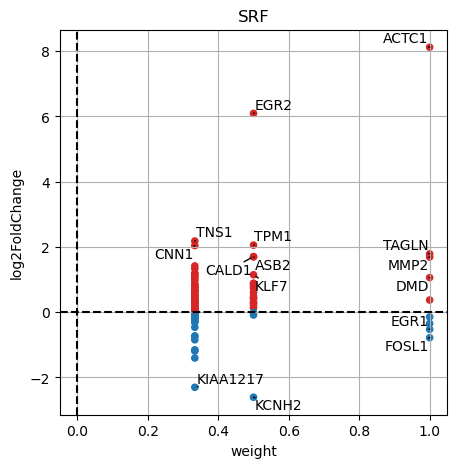

In [28]:
dc.plot_targets(df_deseq2, stat = 'log2FoldChange', source_name = 'SRF', net = dorothea_abc, top = 15)

Still looking at one interesting TF, we can also visualise the targets on a volcano plot. The first two lines only transpose and rename the two columns that we use here, in order to create suitable input for the plotting function.

C:\Users\pablo\micromamba\envs\permedschool\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


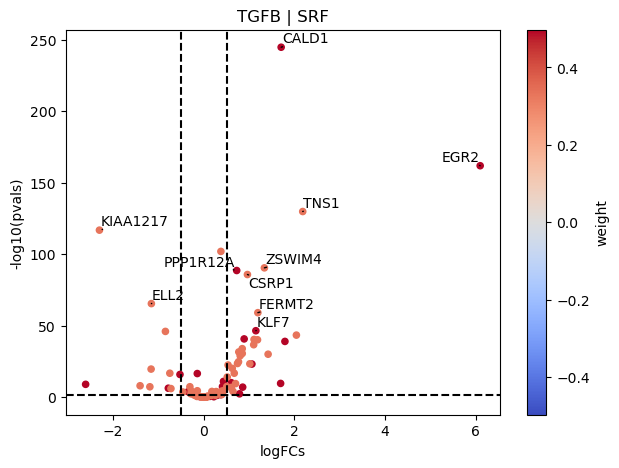

In [29]:
logfcs = df_deseq2[['log2FoldChange']].T.rename(index = {'log2FoldChange': 'TGFB'})
pvals = df_deseq2[['padj']].T.rename(index = {'padj': 'TGFB'})

dc.plot_volcano(logfcs, pvals, 'TGFB', name = 'SRF', net = dorothea_abc, top = 10, sign_thr = .05, lFCs_thr = .5)

## 3.3. Pathway activities

Above we introduced PROGENy<sup>9</sup>, a collection of transcriptional signatures of canonical pathways. The same way as with TF activities, if a pathway is activated, we expect the expression of its signature genes to go up or down, depending on the sign of the relationship. The only difference is that here the relationships between pathways and genes are indirect, each pathway has a large number of affected genes, all with continuous scores that express the strenght of the relationship. In the example below, we restrict the analysis to the top 300 signature genes with the highest scores.



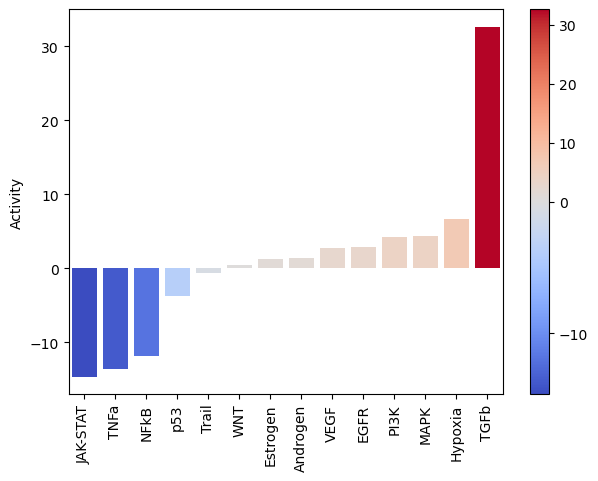

In [30]:
progeny300 = dc.get_progeny(top = 300)

# Infer pathway activities with consensus
pathway_acts = dc.run_wmean(mat = de_matrix, net = progeny300)

dc.plot_barplot(pathway_acts[1], 'TGFB', top = 25, vertical = False)

Not surprisingly, the inferred activity change of the TGF-beta pathway is by far the highest. We can expect that the genes with positive weights in the signature are upregulated, while the ones with negative weights are downregulated in their expression. Indeed, the few ones that go against this expectation are shown in blue below:

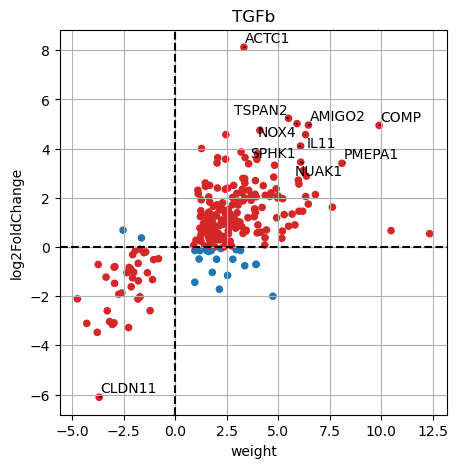

In [31]:
dc.plot_targets(df_deseq2, stat = 'log2FoldChange', source_name = 'TGFb', net = progeny300)

## 3.4. Single-cell transcriptomics

Decoupler works seamlessly with single-cell data: the first argument `mat` for each method can be an [`AnnData`](https://anndata.readthedocs.io/en/latest/)<sup>11</sup> object the object used for scRNA-Seq data processing and analysis by [`Scanpy`](https://scanpy.readthedocs.io/en/stable/)<sup>12</sup>, the core component of the [scverse framework](https://scverse.org/)<sup>13</sup>. Enrichment and activities are calculated for each sample (droplet). You can see in the [Decoupler tutorials](https://decoupler-py.readthedocs.io/en/stable/notebooks/dorothea.html) how easy this procedure is. With scRNA data the coverage is typically lower than in bulk RNA-Seq, however [our analysis has shown](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1949-z)<sup>14</sup> that the activity inference still works well.

# 4. Finding causal signaling networks from perturbations to TFs with CARNIVAL



We have observed how we can move from gene expression data (consisting of approximately 20,000 genes) to transcription factor activities (about 300 genes). This process can provide us with a better comprehension of the transcriptional program that was stimulated by the intracellular signaling response of a cell to a specific perturbation.

Nonetheless, to gain a deeper understanding of why a particular transcriptional program was prompted by a cell, we must connect the perturbation to transcription factors. This approach will enable us to explore different questions related to signaling, such as why two cells respond differently to the same drug. Additionally, we can identify potential targets that may be used for new therapies.


This process is usually systematically done by checking bibliography, gene functions and networks to identify potential targets that can explain the changes observed in our samples. Instead of doing this process in a manual fashion, we will leverage the power of Omnipath CARNIVAL to automatically explore this for us. 


## 4.1. CARNIVAL with Python




<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/carnival_graphical_abstract.png?" alt="carnival" width="800"/>
<figcaption>
<strong>Figure 7. CARNIVAL workflow.</strong> CARNIVAL uses database knowledge of molecular interactions (network) to find subnetworks that give the most plausible explanation of the observed molecular activities, and to predict the activities of other related components.
</figcaption>
</figure>


Carnival was originally implemented in R using the IBM CPLEX solver. For this course, we will use a new re-implementation of Carnival in Python using **CORNETO**, *a new experimental library* we are developing for modelling biological network inference problems in Python with support for many solvers. The only important thing to know at this point is that **we will run CARNIVAL using a CORNETO implementation**. For a better understanding about carnival and corneto, please see `6.1 Advanced Carnival` at the end of the notebook. 

We first need to import corneto and check that everything is ok.

In [32]:
import corneto as cn
cn.info()

CORNETO v0.9.1-alpha.0 (latest: v0.9.1-alpha.1)
Available backends:  CVXPY v1.3.1
Default backend (corneto.K): CVXPY
Available solvers for CVXPY: CBC, ECOS, ECOS_BB, OSQP, SCIP, SCIPY, SCS
Graphviz available: v0.20.1.
https://github.com/saezlab/corneto


The output shows that we have corneto installed with [CVXPY](https://www.cvxpy.org/) as a backend, a Python modeling library for convex optimization. We also see that we have many solvers installed. Both CVXPY and solvers are needed to translate from a CARNIVAL problem to an optimal solution, a task that is not easy for large networks. 

We don't need to worry about this, we will only use the `carnival` method implemented in CORNETO. 

## 4.2. Understanding CARNIVAL: Causal reasoning about changes in activity


Carnival infers a network from the footprint of a perturbation (gene expression changes) to the signaling pathway that links the perturbation with the TFs that explain the observed changes in gene expression. For this, it exploits the information of a PKN containing known signed interactions between signaling proteins, and it searches across the space of potential networks that can lead to the observed changes in TF activity. The following figure shows the simple rules to infer changes in activity of unmeasured proteins:

<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/carnival-causal-reasoning.png" alt="maxflow" width="600"/>
<figcaption>
<strong>Figure 8. The formal logic of causal reasoning.</strong>
</figcaption>
</figure>

For example, if we have in our prior knowledge that `A` activates `B`, and from a contrast experiment we have measured that `B` increases . Note that one assumption is that our prior knowledge is complete and correct. However, this assumption is not different from what we do manually in practice: you observe some changes in some genes, you check the bibliography to see which are the key proteins that can explain those changes. Instead of doing this manually and case by case, CARNIVAL does it for you, integrating many measurements at the same time and finding the most parsimonious network.

CORNETO includes some useful methods to import and create prior knowledge networks that are ready to be processed by CARNIVAL. Let's see how to create a small example through the `Graph` interface. The method `from_sif_tuples` allows us to parse a list of tuples `(A, 1, B)` which indicates a direct activation edge from A to B, or `(A, -1, B)` which indicates a direct inhibition from A to B.

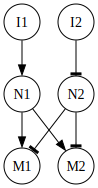

In [33]:
G = cn.Graph.from_sif_tuples(
    [
        ('I1',  1, 'N1'), # I1 activates N1
        ('N1',  1, 'M1'), # N1 activates M1
        ('N1',  1, 'M2'), # N1 activaes M2
        ('I2', -1, 'N2'), # I2 inhibits N2
        ('N2', -1, 'M2'), # N2 inhibits M2
        ('N2', -1, 'M1')  # N2 inhibits M1
    ]
)
G.plot()

> **4.2-Q1. Question**: assume that in the network above, I1 and I2 are receptors, and M1 and M2 are TFs. We observe that M1=-1 (downregulated activity). Can you find a signal from a receptor to M1 that explains the downregulation in activity of M1?  

> 4.2-A1: Your answer here

Now, we are going to run CARNIVAL on this small network. Let's assume that I1 and I2 are the perturbed input nodes (e.g receptors), and M1 and M2 are the measured nodes (e.g. Transcription Factors). For simplicity let's assume also that I1 and I2 are activated, as well as for M1 and M2:

In [34]:
from corneto.methods import runVanillaCarnival

# These are the measurements (e.g. TF activity from Decoupler).
# Positive values correspond to up-regulation and negative values
# with down-regulation. The bigger the absolute value is, 
# the bigger the importance is
measurements = {'M1': 1, 'M2': 1}

# Perturbations are the upstream nodes were the signal originates on, 
# for example, ligands or receptors.
perturbations = {'I1': 1, 'I2': 1}

# We run the `standard` carnival problem. This interface is similar
# to the old R function https://saezlab.github.io/CARNIVAL/reference/runVanillaCarnival.html
p, Gf = runVanillaCarnival(perturbations, measurements, G)

The method `runVanillaCarnival` returns a CORNETO problem and an extended graph that encodes the carnival problem. What is important for now is to know that the problem contains the values for the edges and vertices of the carnival solution. We can plot the solution easily with:

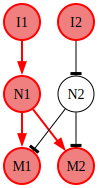

In [35]:
G.to_graphviz(problem=p)

## 4.3. Manipulating the CARNIVAL problem with CORNETO


After running `runVanillaCarnival` method, we obtain a graph and a problem. The graph is similar to our PKN but with some extra dummy nodes required for CARNIVAL. The `problem` is more interesting. It contains the variables for edges and nodes together with the optimal values found by the solver, although this process was transparent to you.

The problem object has a method `solve` to directly solve the carnival problem. We can pass the argument `verbosity=1` to see what happens behind:

In [36]:
p, Gf = runVanillaCarnival(perturbations, measurements, G)
p.solve(verbosity=1)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 01 03:51:19 PM: Your problem has 86 variables, 31 constraints, and 0 parameters.
(CVXPY) Jun 01 03:51:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 01 03:51:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 01 03:51:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 01 03:51:19 PM: Compiling problem (target solver=CBC).
(CVXPY) Jun 01 03:51:19 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

Problem(Minimize(Expression(AFFINE, UNKNOWN, (1,))), [Inequality(Constant(CONSTANT, ZERO, (14,))), Inequality(Variable((14,))), Inequality(Constant(CONSTANT, ZERO, (10,))), Inequality(Variable((10,), boolean=True)), Inequality(Constant(CONSTANT, ZERO, (14,))), Inequality(Variable((14,), boolean=True)), Inequality(Constant(CONSTANT, ZERO, (14,))), Inequality(Variable((14,), boolean=True)), Inequality(Constant(CONSTANT, ZERO, (10,))), Inequality(Variable((10,), boolean=True)), Inequality(Constant(CONSTANT, ZERO, (14,))), Inequality(Variable((14,), boolean=True)), Inequality(Constant(CONSTANT, NONNEGATIVE, (10,))), Inequality(Variable((10,))), Equality(Expression(AFFINE, UNKNOWN, (10,)), Constant(CONSTANT, ZERO, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (14,))), Inequality(Variable((14,))), Equality(Expression(AFFINE, NONNEGATIVE, (2,)), Expression(AFFINE, NONNEGATIVE, (2,))), Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CO

We see that the problem was processed by `CVXPY` and the solver `GLPK_MI` was used to solve the CARNIVAL problem. Through `problem`, we can manipulate things of the original CARINVAL and re-run to find alternative solutions. This is interesting since we can add extra knowledge to our problem and see what happens, to investigate new hypothesis. 

Here is a small example to have a taste about why this is useful. For example, what happens if we know that N1 is upregulated?

In [37]:
# Example: we say that N1 has to be active
p1 = set_problem_value(p, Gf, 'N1', 1)
p1.solve();

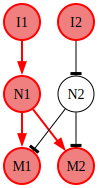

In [38]:
# An alternative explanation
G.to_graphviz(problem=p1)

## 4.4. From perturbations to TFs: a larger example

We will import a Prior Knowledge Network of a toy signaling model (LiverDREAM) in a Signed Interaction Format (SIF). The SIF format specifies interactions using three values per line. A line `A, 1, B` indicates a direct edge (activation) from `A` to `B`, whereas a line `A, -1, B` indicates an inhibitory interaction.

In [39]:
!cat permedcoe/dataset/PKN-LiverDREAM.sif.txt

"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


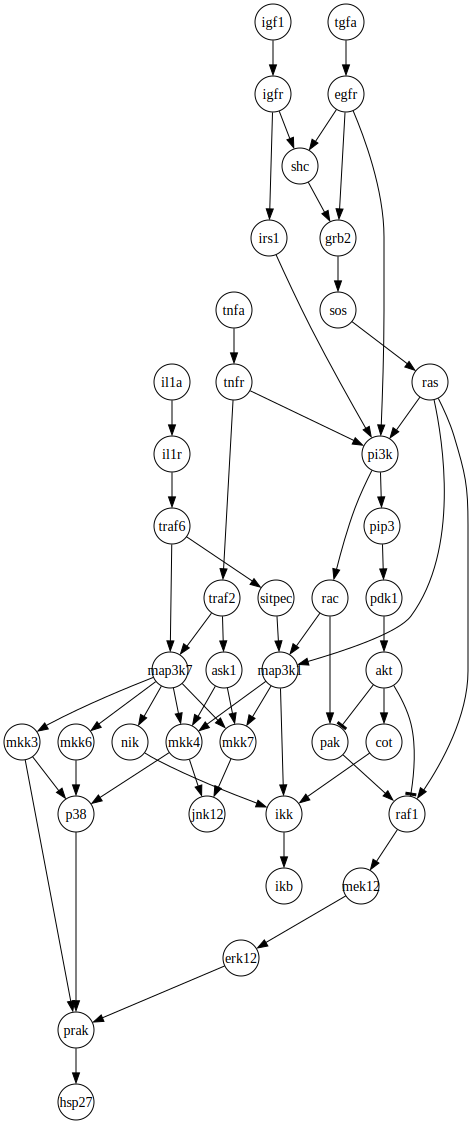

In [41]:
G = cn.Graph.from_sif('dataset/PKN-LiverDREAM.sif.txt')
G.plot()

This network can represent a context-inespecific signaling network of a mammalian cell. Imagine now that we run an experiment where we have control cells and cells stimulated with TGF-α (vertex `tgfa` in the graph). We then compare the activity of some proteins (e.g with (phospho)proteomics) and we observe that `erk12` and `p38` show more activity after treatment.

 Let's see how to model this with CARNIVAL. We need to define the inputs (in this case, activation of TGF-α) and the outputs (ERK12=+1 and p38=+1):

In [42]:
perturbations = {'tgfa': 1}
measurements = {'erk12': 1, 'p38': 1}
problem, carnival_graph = cn.methods.runVanillaCarnival(perturbations, measurements, G)

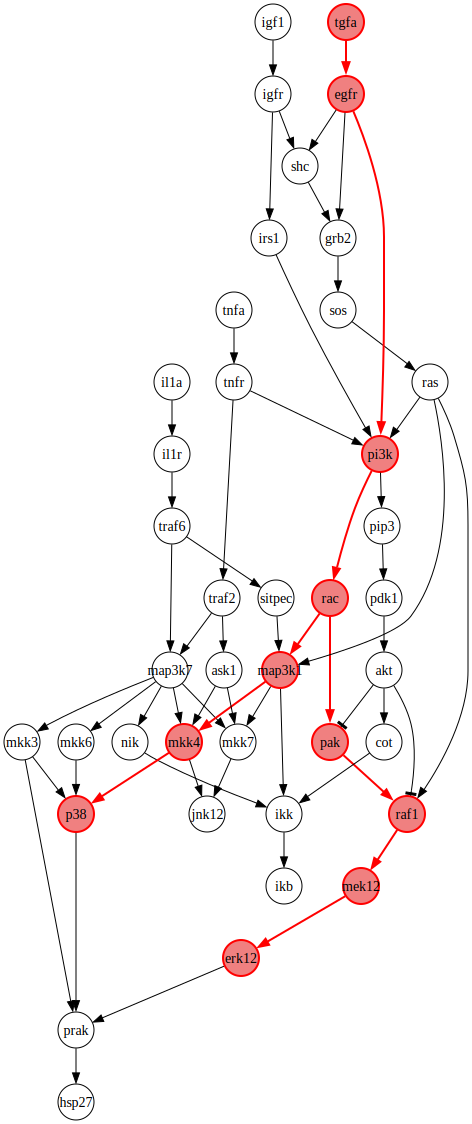

In [43]:
G.to_graphviz(problem=problem)

## Assignments

### 4. A1

We stimulate the cell now with Insuline-like growth factor 1 (igf1) instead of TGF-α. Assume that the measurements are the same as before. Obtain the corresponding network.

> Question: which color (red=+1/white=0/blue=-1) has the `Ras` protein?

In [44]:
# your code here


### 4. A2

Now, let's assume that cells are only stimulated with TGF-a, and you observe that `raf1` is inhibited and `erk12` activated. How the network looks like in this case? Plot the result.

> Question: which color has the `raf1` protein? and `erk12`?

In [45]:
# your code here

### 4. A3

Take again the 4.A1 example, where `igf1` is the perturbation (activated), and `erk12` and `p38` the measurements (activated). However, this time assume that you have knowledge that `pi3k` is activated and part of the solution. Recompute the solution in this case. What is the color of `ras` protein?

> Hint: use the `set_problem_value` method we saw at the beginning of Sec. 4.3 to force `pi3k` to take the value 1. Note that this is different as adding `pi3k` as a measurement.

In [46]:
# your code here

# 5. Putting everything into practice with real data


Now it's time to put in practice what we have learnt. For this, we are going to use data from [PANACEA](https://www.synapse.org/#!Synapse:syn21763589/wiki/601659), a DREAM challenge for elucidation of the mechanisms of action of different kinases inhibitors on cancer. In this dataset, we have the transcriptional profile of different cancer cells to 32 kinases inhibitors. 

For this tutorial, we are going to use the DU-145 cell line data (human prostate cancer cell line), we are going to infer the transcriptional program of the cell for each drug with Decoupler, and we are going to pick one particular drug to infer a signaling network.<br><br>

<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/panacea-fig.png" alt="knapsack" width="600"/>
<figcaption>
<strong>Figure 9. Design of the PANACEA DREAM Challenge.</strong>
</figcaption>
</figure>

To simplify the things a little bit, we have already proccessed the data for the DU-145 cell line, and we performed differential expression analysis between controls (cells with DMSO treatment) and treatments with drugs (data collected after 24h of exposition).


## 5.1. Download and import the dataset

For convenience, we have already preprocessed the transcriptomics data for the DU-145 cell line, for the control (DMSO) and the transcriptional profile of the 32 kinase inhibitors. Contrasts between Treatment vs Control were performed using LIMMA for differential analysis, and results were combined in a single csv file. The resulting file contains for each gene, the LIMMA parameters such as moderated t statistic, p-value, fold-change, etc. 

We are going to download and unzip the content. The zip file contains also a README.txt with a full description of the preprocessing done to the raw data.

In [48]:
#!unzip permedcoe/dataset/panacea.zip
from zipfile import ZipFile as zip
with zip('dataset/panacea.zip', 'r') as zf:
    zf.extractall('.')

In [52]:
#!cat panacea/README.txt
with open('panacea/README.txt', 'rb') as f:
    print(f.read().decode('utf-8'))

The raw counts for DU145 cell lines were obtained from the Gene Expression Omnibus entry GSE186341. Lowly expressed genes were removed using the edgeR filterByExpr function. The differential expression analysis between the treated (kinase inhibitors) and untreated (DMSO) samples was performed using the limma-trend approach. Firstly, the counts were normalized using the Trimmed Mean of M-values approach, and then transformed into counts per million (CPMs). The CPM values were then compared between the treated and untreated samples using limma. The resulting tables include an estimate of the effect size of the change, a statistical estimate (e.g. T values) and a significance estimate (adjusted P value) of the change in response to each treatment in the dataset.

Author: Martín Garrido Rodríguez-Córdoba <martin.garrido@embl.de>




In [53]:
# We will use pandas to load dataframes 
import pandas as pd

# PANACEA DU-145 Treatment vs Control (32 kinase inhibitors as treatments, control DMSO)
df_panacea = pd.read_csv('panacea/panacea.csv')
df_panacea.head()

,gene,logFC,AveExpr,t,P.Value,adj.P.Val,B,contrast
0,GLMP,-1.533270,5.234243,-4.969321,0.000002,0.025465,2.007286,DACOMITINIB-DMSO
1,IRF6,-3.022769,2.835268,-4.147802,0.000060,0.256666,0.023416,DACOMITINIB-DMSO
2,DMAC1,-0.764417,6.912396,-4.136381,0.000063,0.256666,-0.002540,DACOMITINIB-DMSO
3,ASIC1,-1.917409,3.211175,-3.994881,0.000108,0.316739,-0.320054,DACOMITINIB-DMSO
4,HNF1B,-1.887455,3.835072,-3.945813,0.000130,0.316739,-0.428367,DACOMITINIB-DMSO


> **5.1-Q1 Question**: which are the top 5 most affected genes by LAPATINIB drug (genes that show the largest absolute effect size or LogFC)? Create a volcano plot with Decoupler
>> TIP: You can get a subset of the dataframe with `df_panacea[df_panacea.column_name == 'value']`

In [54]:
# 5.1-A1 code for answer

Now, we will prepare the differential expression dataframe to be used with Decoupler. For this, we need to put the conditions (drugs) as rows, and genes as columns. We can use the `pivot` method [from pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html).

In [55]:
# Here, LIMMA was used as the linear model for testing, and the moderated 
# t-statistic (t) is the column we will use to assign values for each gene/drug.
# These values will be used for the enrichment test in Decoupler.
df_differential_analysis = df_panacea.pivot(index='contrast', columns='gene', values='t')
df_differential_analysis.head()

gene,A1BG-AS1,A2M-AS1,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
contrast,,,,,,,,,,,,,,,,,,,,,
AEE788-DMSO,1.071176,0.960408,-0.387508,1.866703,-0.769665,-2.911092,-0.265391,1.457491,-0.694798,-0.276921,...,1.646816,1.151379,-0.759036,-0.334819,-2.100825,-0.574978,-1.338866,2.388873,0.574207,-1.073677
AFATINIB-DMSO,-0.747972,1.424949,0.817884,0.085568,0.119139,0.228957,1.133671,-0.980007,-0.448743,1.481979,...,0.761940,-0.956599,0.624453,-1.100996,-2.100825,0.266645,-2.092996,-1.082792,0.423500,1.699526
AZD5363-DMSO,1.604877,0.959802,-0.451428,-0.573895,-1.424303,-0.846673,0.930989,0.122182,-0.601979,0.547009,...,-0.288122,0.933968,1.082086,-1.100996,0.064395,0.736621,-1.080824,-2.240034,-0.912340,0.704897
BAFETINIB-DMSO,1.701826,0.049725,-0.398428,-0.254057,0.554880,0.305161,0.025093,-0.230327,1.297891,0.751023,...,-0.162775,-0.026056,-1.270673,1.515962,-0.523424,1.111975,0.015295,2.114835,1.285860,-2.393474
BOSUTINIB-DMSO,-1.293843,0.205803,-0.084557,-0.092892,-0.012286,0.368860,-0.077168,0.832060,-0.631431,0.337568,...,1.814425,1.136093,1.301641,0.033328,-1.544174,-0.256288,-1.394846,0.769991,0.371694,0.378180


## 5.2. Estimate TF activities with Decoupler

In [56]:
# https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html
import decoupler as dc

net = dc.get_dorothea(organism='human', levels=['A','B','C'])
net

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [57]:
tf_estimation, p_vals = dc.run_mlm(mat=df_differential_analysis, net=net, source='source', target='target', weight='weight', verbose=True)
tf_estimation.head()

Running mlm on mat with 32 samples and 12204 targets for 278 sources.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
AEE788-DMSO,1.530737,-0.644328,-0.463537,-0.951382,-0.770795,-0.738250,-0.286374,0.454096,-0.111231,0.751576,...,0.200499,-1.026714,1.203317,-0.157918,-1.808794,-1.480756,0.043425,-1.807872,0.102801,-1.437833
AFATINIB-DMSO,0.066131,-0.866910,0.972003,-1.493532,-0.025959,-0.838545,-0.047258,1.534634,-0.253968,-1.359771,...,1.035659,-0.786511,-0.687860,-2.498894,0.423469,0.244571,-1.041320,0.245124,1.761517,0.812881
AZD5363-DMSO,-0.346871,0.792055,-1.744481,-1.851617,0.790182,1.443817,0.289276,0.157008,-0.940690,-4.045668,...,-1.108269,-0.417181,1.079303,-0.858021,-1.582403,-1.041440,-0.129818,-1.152337,0.787089,-1.462244
BAFETINIB-DMSO,1.384168,-1.362105,-0.632436,-1.832749,-1.443249,-0.125506,1.294920,0.042113,0.436501,-2.330456,...,0.348873,-0.276648,1.820069,0.933328,-0.999613,1.667517,-0.169357,-2.060236,-0.654825,0.247103
BOSUTINIB-DMSO,0.693355,-1.233976,0.531789,-0.112879,-0.277540,-1.044027,0.404707,-1.920163,-0.759365,-0.515785,...,-1.096212,0.409898,-0.954694,0.439186,-0.524079,0.649842,-0.576365,-1.503532,1.311455,0.507941



> **5.2-Q1. Question:** how would you choose the top-3 most similar drugs to LAPATINIB in terms of TF activity profile? (*HINT: some Pandas functions can be of help with this https://pandas.pydata.org/pandas-docs/stable/reference/frame.html*)

In [58]:
# 5.2-Q1 your code here

A very quick and unsupervised way to identify similarities between drugs is to find some top N transcription factors that show high variability across drugs, and use those to cluser drugs by similarity. We can do this quickly with Pandas and Seaborn using the `clustermap` function:

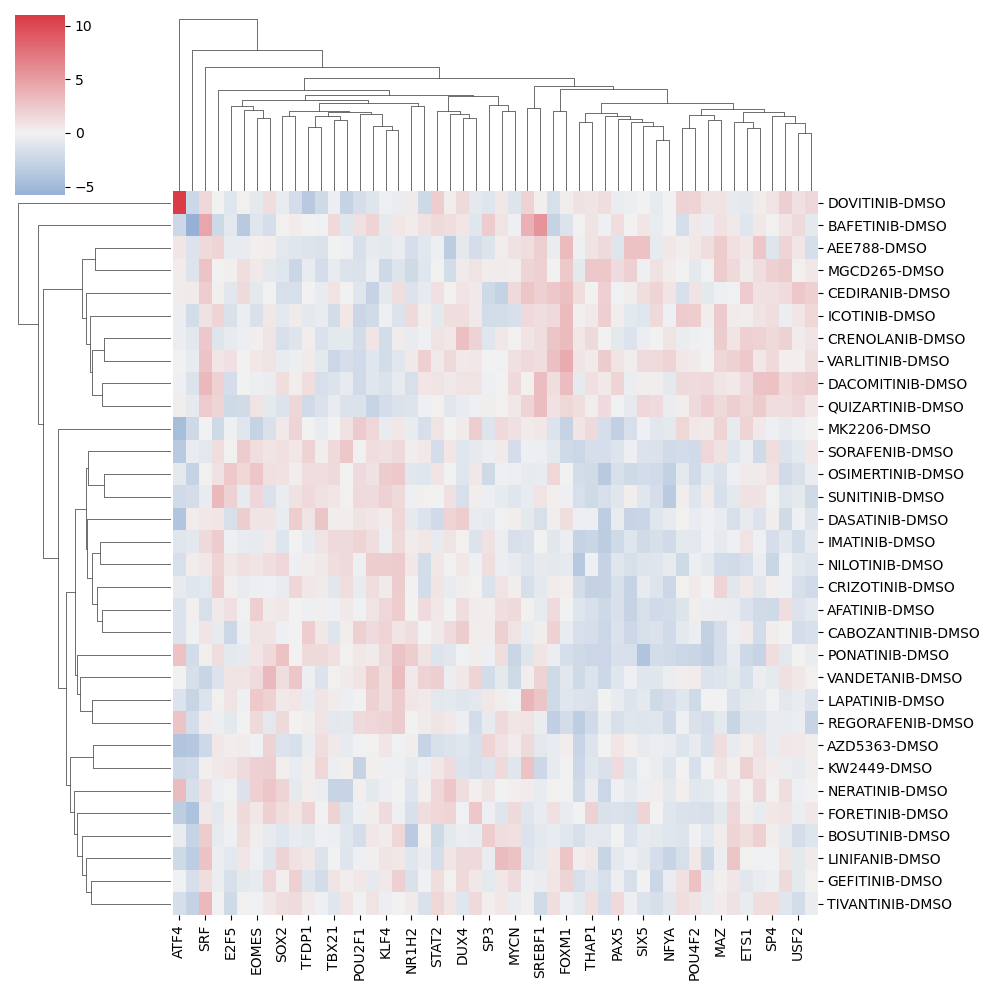

In [59]:
import seaborn as sns 

# We calculate top 50 most variable TFs across drugs
top_variable_tfs = tf_estimation.std(axis=0).sort_values().tail(50)

# Colormap from blue (decreased activity) to red (increased activity)
cmap = sns.diverging_palette(250, 10, center='light', as_cmap=True)
cmap.set_bad(color='white')

# Clustermap using only the selected TFs (columns of the dataframe)
sns.clustermap(tf_estimation.loc[:, top_variable_tfs.index], cmap=cmap, center=0);

Now, let's focus our attention for example to **Lapatinib drug**. We can easily plot top `N` TFs by absolute effect size in DU-145 with decoupler using the `plot_barplot` function:

In [60]:
# Analysis of drug
treatment = 'LAPATINIB-DMSO'

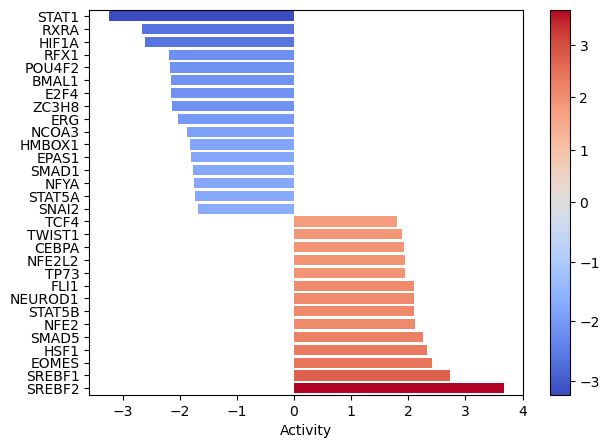

In [61]:
dc.plot_barplot(tf_estimation, treatment, top=30, vertical=True)

Another interesting thing we can do is to filter also by p-value, so we can get TFs whose changes between treatment and control are statistically significant (even though the effect size can be low)

In [62]:
significant_tfs = p_vals.loc[treatment, p_vals.loc[treatment] <= 0.05]
significant_tfs

BMAL1      0.031045
E2F4       0.031113
EOMES      0.015389
ERG        0.042492
FLI1       0.035562
HIF1A      0.009238
HSF1       0.019479
NEUROD1    0.035530
NFE2       0.034442
POU4F2     0.030116
RFX1       0.028727
RXRA       0.007801
SMAD5      0.024504
SREBF1     0.006184
SREBF2     0.000245
STAT1      0.001219
STAT5B     0.035508
ZC3H8      0.032625
Name: LAPATINIB-DMSO, dtype: float64

## 5.3. Obtain a prior knowledge network of signaling with OmniPath


From DrugBank: "Lapatinib is a 4-anilinoquinazoline kinase inhibitor of the intracellular tyrosine kinase domains of both epidermal growth factor receptor (HER1/EGFR/ERBB1) and human epidermal growth factor receptor type 2 (HER2/ERBB2)with a dissociation half-life of ≥300 minutes"

In [63]:
drug_targets = ['EGFR', 'ERBB2']

In [64]:
import omnipath as op

# We get only interactions from SIGNOR http://signor.uniroma2.it/
pkn = op.interactions.OmniPath.get(databases=['SIGNOR'], genesymbols=True)
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,Q13976,Q13507,PRKG1,TRPC3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,Q13976,Q9HCX4,PRKG1,TRPC7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q13438,Q9HBA0,OS9,TRPV4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P18031,Q9H1D0,PTPN1,TRPV6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P63244,Q9BX84,RACK1,TRPM6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


Given that we are running this on Google Colab and using free solvers, we can end up having problems solving CARNIVAL on big networks. To avoid this problem, we can decrease the size of the initial network by keeping only well curated interactions.

In [65]:
subset_pkn = pkn[(pkn.curation_effort >= 6) & (pkn.consensus_direction==True)]
subset_pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,Q13976,Q13507,PRKG1,TRPC3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
3,P18031,Q9H1D0,PTPN1,TRPV6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
6,Q16539,P49137,MAPK14,MAPKAPK2,True,True,False,True,True,False,63,ACSN:11274345;ACSN:12738796;ACSN:15187187;ACSN...,ACSN;BEL-Large-Corpus_ProtMapper;BioGRID;CA1;C...,37,24,34,10581204;10922375;11042204;11274345;11551945;1...
7,P49137,Q13151,MAPKAPK2,HNRNPA0,True,True,False,True,True,False,10,HPRD:12456657;PhosphoSite:26602816;ProtMapper:...,HPRD;PhosphoPoint;PhosphoSite;PhosphoSite_Prot...,12,8,6,12456657;17287340;20932473;21173571;25716654;2...
8,P49137,O95453,MAPKAPK2,PARN,True,False,True,True,False,True,10,PhosphoSite:20932473;ProtMapper:20932473;SIGNO...,HPRD_MIMP;MIMP;PhosphoSite;PhosphoSite_MIMP;Ph...,15,7,5,16964243;18669648;19690332;20932473;21173571


In [66]:
def as_tuples(df):
    return list(set((r.source_genesymbol, 
           int(r.is_stimulation) - int(r.is_inhibition), 
           r.target_genesymbol) for _, r in df.iterrows()))

# We call corneto method 'from_sif_tuples' to create a Graph for carnival
G_pkn = cn.Graph.from_sif_tuples(as_tuples(subset_pkn))
G_pkn.num_edges, G_pkn.num_vertices

(4251, 2344)

We can see that the interactions are now imported as a graph. We can plot interactions between nodes by obtaining a sugraph with CORNETO. For example, let's check if the first row of the PKN dataframe matches what we have in the graph:

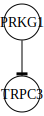

In [67]:
G_pkn.subgraph(['PRKG1', 'TRPC3']).plot()

> **5.3-Q1 Question:** which type of interaction exists between `MTOR` and `ULK2` ?

In [68]:
# 5.3-A1: your code here

## 5.4. Run Carnival to infer a signaling network from perturbations to TFs

In [69]:
# Select row `treatment` (LAPATINIB), and as columns, only the genes with p-val <= 0.05
# NOTE: The absolute value of the measurements is used to weight the importance
sel_measurements = tf_estimation.loc[treatment, significant_tfs.index]
sel_measurements

BMAL1     -2.156748
E2F4      -2.155885
EOMES      2.423441
ERG       -2.028883
FLI1       2.102140
HIF1A     -2.603548
HSF1       2.336556
NEUROD1    2.102504
NFE2       2.115102
POU4F2    -2.168822
RFX1      -2.187479
RXRA      -2.661014
SMAD5      2.249413
SREBF1     2.738353
SREBF2     3.668945
STAT1     -3.235283
STAT5B     2.102758
ZC3H8     -2.136912
Name: LAPATINIB-DMSO, dtype: float32

In [70]:
# Run carnival from drug target of DASATINIB
drug_targets = {'EGFR': -1, 'ERBB2': -1}
drug_tf_measurements = sel_measurements.to_dict()

# Pre-processing: prune the graph based on unreachable nodes
G_pkn_pruned = G_pkn.prune(drug_targets.keys(), drug_tf_measurements.keys())
G_pkn_pruned.num_edges, G_pkn.num_vertices

(948, 2344)

In [71]:
problem, carnival_graph = cn.methods.runVanillaCarnival(
    drug_targets, 
    drug_tf_measurements, 
    G_pkn_pruned,
    solver='SCIP',
    verbosity=1)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 01 03:54:25 PM: Your problem has 4773 variables, 33 constraints, and 0 parameters.
(CVXPY) Jun 01 03:54:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 01 03:54:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 01 03:54:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 01 03:54:25 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jun 01 03:54:25 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [73]:
se, sv = get_selected_edges_and_nodes(carnival_graph, problem)
len(se), len(sv)

(40, 31)

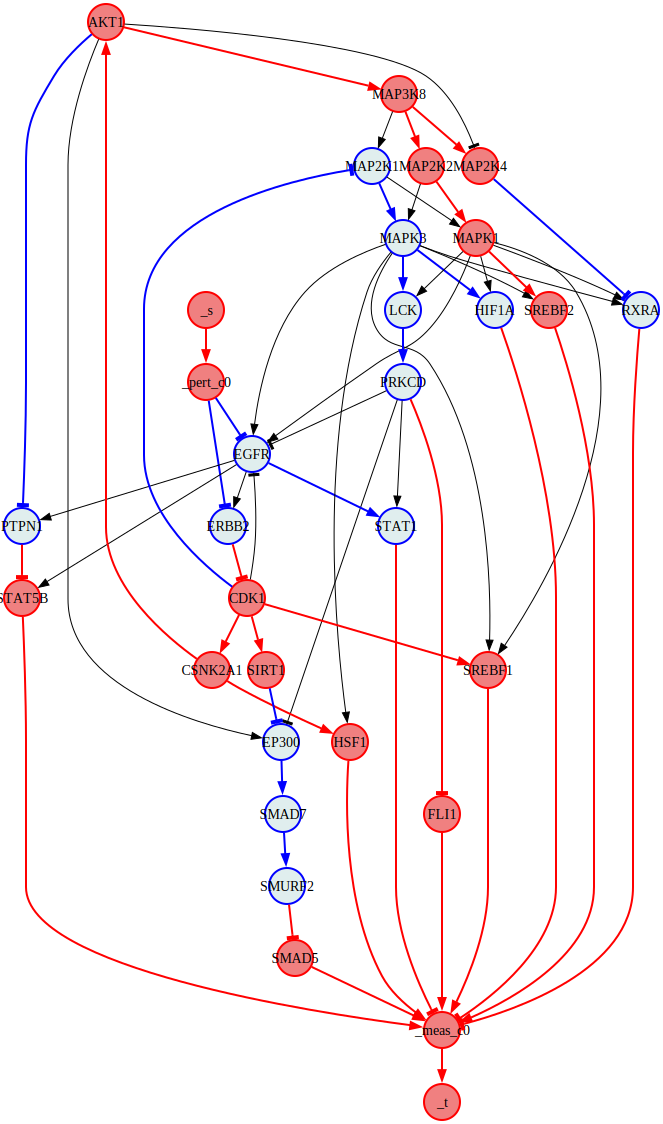

In [74]:
plot(carnival_graph.subgraph(sv), format=get_problem_values(carnival_graph, problem))

# 6. Advanced topics (Optional)

## 6.1 Advanced CARNIVAL with CORNETO

### 6.1.1. Constrained optimization with CORNETO

CORNETO is a specialized library for creating and solving network problems for biology. These type of problems usually require solving discrete/continuous optimization functions. For this, CORNETO relies on different libraries, such as CVXPY and PICOS, for converting a mathematical specification into an optimization problem that can be solved using specialized software such as Gurobi, CPLEX, CBC, SCIP, and other solvers. One of the features CORNETO provides is an abstraction layer (so different backends like CVXPY/PICOS can be used) to transform a high level specification problem into a convex/non-convex constrained optimization problem. To understand better this, we will see how to use CORNETO as an interface to define constrained optimization problems.

In [75]:
import corneto as cn
cn.info()

CORNETO v0.9.1-alpha.0 (latest: v0.9.1-alpha.1)
Available backends:  CVXPY v1.3.1
Default backend (corneto.K): CVXPY
Available solvers for CVXPY: CBC, ECOS, ECOS_BB, OSQP, SCIP, SCIPY, SCS
Graphviz available: v0.20.1.
https://github.com/saezlab/corneto


In [76]:
solver='SCIP'

#### The Knapsack problem

This is a typical combinatorial optimization problem with constraints. The goal is to put in your backpack as much objects as possible without exceeding the total capacity of your backback.

#### Example 1

<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/knapsack-wikipedia.png" alt="knapsack" width="400"/>
<figcaption>
<strong>Figure 10. Illustration of the Knapsack problem.</strong>
</figcaption>
</figure>

In [77]:
obj1 = cn.K.Variable('obj1', 1, vartype=cn.VarType.BINARY)
obj2 = cn.K.Variable('obj2', 1, vartype=cn.VarType.BINARY)
obj3 = cn.K.Variable('obj3', 1, vartype=cn.VarType.BINARY)
obj4 = cn.K.Variable('obj4', 1, vartype=cn.VarType.BINARY)
obj5 = cn.K.Variable('obj5', 1, vartype=cn.VarType.BINARY)

total_value = 4*obj1 + 2*obj2 + 10*obj3 + 1*obj4 + 2*obj5
weight = 12*obj1 + 1*obj2 + 4*obj3 + 1*obj4 + 2*obj5

total_value

Expression(AFFINE, NONNEGATIVE, (1,))

In [78]:
problem = cn.K.Problem(
    constraints=sum(weight)<=15, 
    objectives=sum(total_value), 
    direction=cn.Direction.MAX)
problem

In [79]:
# Variables have the attribute 'value' to see their optimal value
# Before solving the problem, the 'value' attribute is None
obj1.value

In [80]:
# We can see also the variables defined in the problem
# which are stored in a dict
problem.symbols

{'obj5': Variable((1,), boolean=True),
 'obj4': Variable((1,), boolean=True),
 'obj2': Variable((1,), boolean=True),
 'obj3': Variable((1,), boolean=True),
 'obj1': Variable((1,), boolean=True)}

In [81]:
# Now we solve the problem using a specific solver. If solver is not provided
# one is automatically selected by the backend.
sol = problem.solve(solver=solver)
print(f"The max. value you can get with the backpack is ${total_value.value[0]}")

The max. value you can get with the backpack is $15.0


In [82]:
# After solving the problem, we can see if a particular object was selected 
# for the backpack (1=selected, 0=not selected)
obj1.value

array([0.])

In [83]:
# Same for our weight and total_value variables
weight.value, total_value.value

(array([8.]), array([15.]))

In [84]:
# Exercise. Change the maximum weight to 5 kg and show which objects are selected
# ---

#### Example 2

In [85]:
# A larger example from:
# https://developers.google.com/optimization/pack/knapsack

values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]

weights = [
    7, 0, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 0, 36, 3, 8, 15, 42, 9, 0,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 0, 79, 20, 65, 52, 13
]

# We use matrix notation form
obj = cn.K.Variable('obj', len(values), vartype=cn.VarType.BINARY)
total_value = values @ obj # matrix mul (1, values) x (objects, 1)
total_weight = weights @ obj

cn.K.Problem(
    constraints=total_weight <= 850, 
    objectives=total_value, 
    direction=cn.Direction.MAX
).solve(verbosity=1, solver=solver)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 01 03:56:06 PM: Your problem has 50 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 01 03:56:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 01 03:56:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 01 03:56:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 01 03:56:06 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jun 01 03:56:06 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

Problem(Maximize(Expression(AFFINE, NONNEGATIVE, ())), [Inequality(Constant(CONSTANT, ZERO, (50,))), Inequality(Variable((50,), boolean=True)), Inequality(Expression(AFFINE, NONNEGATIVE, ()))])

In [86]:
total_value.value, total_weight.value

(7534.0, 850.0)

#### Network Flow problem

<figure>
<img src="https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023/raw/main/assets/maxflow-example.png" alt="maxflow" width="600"/>
<figcaption>
<strong>Figure 11. Illustration of the max flow problem.</strong>
</figcaption>
</figure>

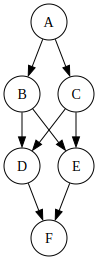

In [87]:
G = cn.Graph.from_sif_tuples(
    [
        ('A', 1, 'B'),
        ('A', 1, 'C'),
        ('B', 1, 'D'),
        ('B', 1, 'E'),
        ('C', 1, 'D'),
        ('C', 1, 'E'),
        ('D', 1, 'F'),
        ('E', 1, 'F')
    ]
)
G.plot()

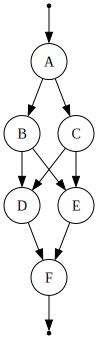

In [88]:
G.add_edge((), 'A') # source
G.add_edge('F', ()) # sink
G.plot()

In [89]:
import numpy as np

problem = cn.K.Flow(G, lb=0, ub=np.array([5, 15, 5, 5, 5, 5, 15, 5, 100, 100]))
problem.symbols

{'_flow_rxn': Variable((10,))}

In [94]:
flows = problem.get_symbol(cn.VAR_FLOW)
# By default the problem is a minimization problem. There are more
# ways to change this but the easiest if we want to maximize flow is to
# add a weight of -1 to the objective, so the function optimized is -1 * fn(x)
# and the minimization problem is converted to maximization one on that function
problem.add_objectives(flows[9], weights=-1)
problem.solve(solver=solver)

Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, ZERO, (10,))), Inequality(Variable((10,))), Equality(Expression(AFFINE, UNKNOWN, (6,)), Constant(CONSTANT, ZERO, ()))])

In [95]:
flows.value

array([ 5., 10.,  5.,  0.,  5.,  5., 10.,  5., 15., 15.])

### 6.1.2. Customizing carnival

First we are going to create a small Prior Knowledge Network (PKN) with few proteins and known interactions

> NOTE: Prior Knowledge Networks can be imported using `cn.Graph.from_sif('file.sif')` to import a SIF (Signed Interaction File) network

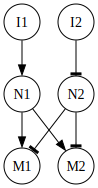

In [96]:
G = cn.Graph.from_sif_tuples(
    [
        ('I1',  1, 'N1'), # I1 activates N1
        ('N1',  1, 'M1'), # N1 activates M1
        ('N1',  1, 'M2'), # N1 activaes M2
        ('I2', -1, 'N2'), # I2 inhibits N2
        ('N2', -1, 'M2'), # N2 activates M2
        ('N2', -1, 'M1')  # N2 activates M1
    ]
)
G.to_graphviz()

In [97]:
from corneto.methods import runVanillaCarnival

measurements = {'M1': 1, 'M2': 1}
perturbations = {'I1': 1, 'I2': 1}
# The method returns the problem definition, and the flow graph for carnival
p, Gf = runVanillaCarnival(perturbations, measurements, G, solver=solver)

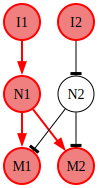

In [98]:
G.to_graphviz(problem=p, graph_attr=dict(size="5"))

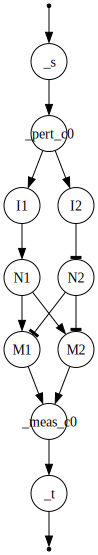

In [99]:
# We can see also the flow graph created for the problem.
Gf.plot()

In [100]:
# Inspect the variables created by CARNIVAL. Note that the size of
p.symbols

{'_flow_rxn': Variable((14,)),
 '_flow_rxn_ipos': Variable((14,), boolean=True),
 'species_activated_c0': Variable((10,), boolean=True),
 'reaction_sends_inhibition_c0': Variable((14,), boolean=True),
 'dag_layer_position_c0': Variable((10,)),
 'species_inhibited_c0': Variable((10,), boolean=True),
 'reaction_sends_activation_c0': Variable((14,), boolean=True)}

In [101]:
# Find an alternative solution by adding new constraints to carnival
# E.g, We know N2 is inhibited, force it
species_values = p.symbols['species_inhibited_c0']
index = Gf.vertices.index('N2')
# We add a new constraint indicating that the variable
# representing if N2 is inhibited is equal to 1 (saying that we know it is)
p += species_values[index] == 1
p.solve();

# References

**1:** A Liu, P Trairatphisan, E Gjerga, A Didangelos, J Barratt, J Saez-Rodriguez (2019) From expression footprints to causal pathways: contextualizing large signaling networks with CARNIVAL. _NPJ Systems Biology and Applications_ 5(40) http://doi.org/10.1038/s41540-019-0118-z

**2:** P Badia-i-Mompel, J Vélez-Santiago, J Braunger, C Geiss, D Dimitrov, S Müller-Dott, P Taus, A Dugourd, CH Holland, RO Ramirez-Flores, J Saez-Rodriguez (2022) decoupleR: ensemble of computational methods to infer biological activities from omics data. _Bioinformatics Advances_ 2(1) https://doi.org/10.1093/bioadv/vbac016

**3:** D Turei, T Korcsmaros and J Saez-Rodriguez (2016) OmniPath: guidelines and
gateway for literature-curated signaling pathway resources. _Nature Methods_
13(12) https://doi.org/10.1038/nmeth.4077

**4:** D Turei, A Valdeolivas, L Gul, N Palacio-Escat, M Klein, O Ivanova,
M Olbei, A Gabor, F Theis, D Modos, T Korcsmaros and J Saez-Rodriguez (2021)
Integrated intra- and intercellular signaling knowledge for multicellular
omics analysis. _Molecular Systems Biology_ 17:e9923 https://doi.org/10.15252/msb.20209923

**5:** JA Bachman, BM Gyori, PK Sorger (2023) Automated assembly of molecular mechanisms at scale from text mining and curated databases. _Molecular Systems Biology_ e11325 https://doi.org/10.15252/msb.202211325

**6:** N Le Novère, M Hucka, H Mi, S Moodie, F Schreiber, A Sorokin, E Demir, K Wegner, MI Aladjem, SM Wimalaratne, FT Bergman, R Gauges, P Ghazal, H Kawaji, L Li, Y Matsuoka, A Villéger, SE Boyd, L Calzone, M Courtot, U Dogrusoz, TC Freeman, A Funahashi, S Ghosh, A Jouraku, S Kim, F Kolpakov, A Luna, S Sahle, E Schmidt, S Watterson, G Wu, I Goryanin, DB Kell, C Sander, H Sauro, JL Snoep, K Kohn, H Kitano (2009) The Systems Biology Graphical Notation. _Nature Biotechnology_ 27(8) https://doi.org/10.1038/nbt.1558

**7:** S Mueller-Dott, E Tsirvouli, M Vazquez, RO Ramirez-Flores, P Badia-i-Mompel, R Fallegger, A Lagreid, J Saez-Rodriguez (2023) Expanding the coverage of regulons from high-confidence prior knowledge for accurate estimation of transcription factor activities. _bioRxiv_ 2023.03.30.534849 https://doi.org/10.1101/2023.03.30.534849

**8:** L Garcia-Alonso, CH Holland, MM Ibrahim, D Turei, J Saez-Rodriguez (2019) Benchmark and integration of resources for the estimation of human transcription factor activities. _Genome Research_ 29(8) https://doi.org/10.1101/gr.240663.118

**9:** M Schubert, B Klinger, M Klünemann, A Sieber, F Uhlitz, S Sauer, MJ Garnett, N Blüthgen, J Saez-Rodriguez (2018) Perturbation-response genes reveal signaling footprints in cancer gene expression. _Nature Communications_ 9(20) https://doi.org/10.1038/s41467-017-02391-6

**10:** B Muzellec, M Telenczuk, V Cabeli, M Andreux (2022) PyDESeq2: a python package for bulk RNA-seq differential expression analysis. _bioRxiv_ https://doi.org/10.1101/2022.12.14.520412

**11:** I Virshup, S Rybakov,FJ Theis, P Angerer, FA Wolf (2021) anndata: Annotated data. _bioRxiv_ https://doi.org/10.1101/2021.12.16.473007 

**12:** FA Wolf, P Angerer, FJ Theis (2018) SCANPY: large-scale single-cell gene expression data analysis. _Genome Biology_ 19(15) https://doi.org/10.1186/s13059-017-1382-0

**13:** I Virshup, D Bredikhin, L Heumos, G Palla, G Sturm, A Gayoso, I Kats, M Koutrouli, Scverse Community, B Berger, D Pe’er, A Regev, SA Teichmann, F Finotello, FA Wolf, N Yosef, O Stegle, FJ Theis (2023) The scverse project provides a computational ecosystem for single-cell omics data analysis. _Nature Biotechnology_ https://doi.org/10.1038/s41587-023-01733-8

**14:** CH Holland, J Tanevski, J Perales-Patón, J Gleixner, MP Kumar, E Mereu, BA Joughin, O Stegle, DA Lauffenburger, H Heyn, B Szalai, J Saez-Rodriguez (2020) Robustness and applicability of transcription factor and pathway analysis tools on single-cell RNA-seq data. _Genome Biology_ 21(36) https://doi.org/10.1186/s13059-020-1949-z

**15:** P Jiang, Y Zhang, B Ru, Y Yang, T Vu, R Paul, A Mirza, G Altan-Bonnet, L Liu, E Ruppin, L Wakefield, KW Wucherpfennig (2021) Systematic investigation of cytokine signaling activity at the tissue and single-cell levels. _Nature Methods_ 18 https://doi.org/10.1038/s41592-021-01274-5